## Creating a PyTorch CNN ADT model

## Loading and preprocessing the data

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchvision
import torch_audiomentations
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import os
import csv
import random

The `n_fft` variable affects the n_fft parameter used in generating melspectrograms and MFCC features used in training and validation. I found the value of `1024` works best, but `2048` can also work well.

In [15]:
dataset_name = "HeartsOnFireDS-v.1.0.2"
n_fft = 1024

df = pd.read_csv(os.path.join(dataset_name, "master.csv"))
train_df = pd.DataFrame()
valid_df = pd.DataFrame()

for idx, row in df.iterrows():
    onsets_path = row['onsets']
    onsets_df = pd.read_csv(onsets_path)
    train_onsets = onsets_df[onsets_df['split'] == 'training']
    valid_onsets = onsets_df[onsets_df['split'] == 'validation']
    
    # Append to respective dataframes
    train_df = pd.concat([train_df, train_onsets], ignore_index=True)
    valid_df = pd.concat([valid_df, valid_onsets], ignore_index=True)

train_df

,Unnamed: 0,onset_time,kick,snare,hihat,tom,crash,ride,other,name,changed,split,click,uncertain
0,0.0,45.429841,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
1,2.0,45.789751,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
2,3.0,45.952290,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
3,4.0,46.114830,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
4,5.0,46.288980,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5361,856.0,208.735782,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,NaN,NaN
5362,859.0,209.235011,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,NaN,NaN
5363,860.0,209.304671,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,NaN,NaN
5364,861.0,209.397551,True,False,False,False,True,False,False,Toehider - To Hide Her,True,training,NaN,NaN


### Setting custom weights based on the amount of classes in dataset

Also possible to alter the weight of the cymbal classes to force the model to be more accurate at classifying them.

In [16]:
counts = train_df.select_dtypes(include=bool).sum(axis=0)
counts = counts.drop(['other', 'changed'])
weights = counts.sum() / (counts * len(counts))
weights_tensor = torch.Tensor(list(weights.values))
#weights_tensor[2] = 1.0 # giving extra weight to the hihat class
weights_tensor

tensor([0.4504, 0.7036, 0.6339, 3.3229, 2.6758, 9.4064])

### Defining the dataset class with a custom transform pipeline

Note the `torch_audiomentations` transforms are implemented differently than the rest of the transforms, requiring the input tensors to be 4D: `[batch, num_channels, freq, time]`. Since we only have a 2D tensor of `[freq, time]`, we will add the extra dimensions and then remove them after we added the necessary data augmentation transforms. 

Bit of a cheaty solution, but I found this method performs the fastest if performed within the transform pipeline.

In [4]:
drum_labels = ['kick', 'snare', 'hihat', 'tom', 'crash', 'ride']

class DrumDataset(Dataset):
    def __init__(self, df, master_csv_path, transform, window_size=8192):
        self.df = df
        self.master_df = pd.read_csv(master_csv_path)
        self.window_size = window_size
        self.transform = transform
        self.audio_cache = {}

        for i, row in self.master_df.iterrows():
            audio_path = row['drums']
            audio, sr = torchaudio.load(audio_path, format="mp3")
            if audio.shape[0] == 2:
                audio = torch.mean(audio, dim=0, keepdim=True)
            self.audio_cache[row['name']] = (audio, sr)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load the onset time, label, and track name for the given index
        row = self.df.iloc[idx]
        onset_time = row['onset_time']
        labels = row[drum_labels].astype(int).values.flatten()
        labels = torch.tensor(labels).float()
        track_name = row['name']
        #print(track_name, onset_time)

        audio = self.audio_cache[track_name][0]
        sr = self.audio_cache[track_name][1]

        onset_window = audio[:, int(onset_time*sr)-self.window_size//2:int(onset_time*sr)+self.window_size//2]
        spec = self.transform(onset_window[0])
        return spec, labels

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.unsqueeze(0).unsqueeze(0)),
    torch_audiomentations.AddColoredNoise(
                min_snr_in_db=3,
                max_snr_in_db=30,
                sample_rate=44100,
                p=0.5,
                output_type='tensor'
            ).to("cuda"),
    torch_audiomentations.Shift(
            min_shift=-0.15,
            max_shift=0.15,
            rollover=False,
            p=0.5,
            sample_rate=44100,
            output_type='tensor'
        ).to("cuda"),
    torch_audiomentations.PitchShift(
            min_transpose_semitones=-1,
            max_transpose_semitones=1,
            p=0.25,
            sample_rate=44100,
            output_type='tensor'
        ).to("cuda"),
    torch_audiomentations.Gain(p=0.5, output_type='tensor').to("cuda"),
    torchvision.transforms.Lambda(lambda x: x.squeeze(0).squeeze(0)),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=n_fft,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
            torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': n_fft, 'hop_length': 64, 'n_mels': 128}
            ).to("cuda")(x)
            ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.to("cpu")),
])

valid_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=n_fft,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
    torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': n_fft, 'hop_length': 64, 'n_mels': 128}).to("cuda")(x)
            ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.to("cpu"))
])

valid_dataset = DrumDataset(valid_df, os.path.join(dataset_name, "master.csv"), valid_transform)
train_dataset = DrumDataset(train_df, os.path.join(dataset_name, "master.csv"), train_transform)

### Getting a random onset and displaying the melspectrogram

4068 tensor([1., 0., 1., 0., 0., 0.])


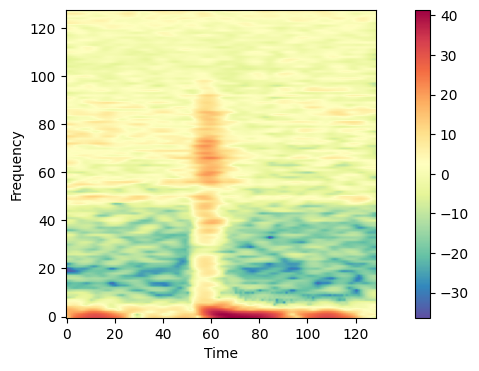

In [27]:
rand = random.randint(1, len(train_df))
a, x = train_dataset.__getitem__(rand)
specgram = a[0].detach().squeeze(0).numpy()
print(rand, x)

plt.figure(figsize=(10, 4))
plt.imshow(specgram, cmap='Spectral_r', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()
#477 

## Defining the model architecture

### Model A

**Initial filter size:** `16`

In [5]:
# Define the neural network architecture
class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(256, len(drum_labels))
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

device = torch.device('cuda')

### Model B

**Initial filter size:** `32`

Thought about increasing the initial filter size to help with identifying hi-hats, performance is worse by 2-4% compared to Model A. Only run the following cell if you want to override Model A.

In [82]:
class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(256, len(drum_labels))
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

## Training

### Hyperparameters

In [10]:
n_epochs = 20
learning_rate = 0.001
batch_size = 16

### Loss function, optimizer, scheduler

In [11]:
def accuracy(outputs, labels, threshold=0.0):
    with torch.no_grad():
        preds = (outputs > threshold).float()
        correct = (preds == labels).sum(dim=1).eq(labels.shape[1]).sum().item()
        total = labels.shape[0]
        return 100 * correct / total

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize the neural network and optimizer
model = DrumCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
start_epoch = 0
valid_loss = 0.0

# Define the loss function
criterion = nn.BCEWithLogitsLoss(weight=weights_tensor.to(device))

### Loading previous checkpoint to continue training

In [12]:
saved_model_dict = torch.load('models/HeartsOnFire-v.1.0.2_nfft1024_88.12.pth', map_location=device)
model.load_state_dict(saved_model_dict['model'])
scheduler.load_state_dict(saved_model_dict['scheduler'])
optimizer.load_state_dict(saved_model_dict['optimizer'])
start_epoch = saved_model_dict['epoch']
n_epochs += start_epoch+1

### Main loop

In [ ]:
for epoch in range(start_epoch, n_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(tqdm(train_loader, total=len(train_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Training")):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_acc += accuracy(outputs, labels) * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    # Evaluate the model on the validation set
    true_labels = []
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(valid_loader, total=len(valid_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Validation")):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            valid_acc += accuracy(outputs, labels) * inputs.size(0)
            true_labels.extend(labels.cpu().numpy().tolist())
            predicted_labels.extend((outputs.cpu() > 0.0).float().numpy().tolist())
        valid_loss /= len(valid_loader.dataset)
        valid_acc /= len(valid_loader.dataset)

        cm = multilabel_confusion_matrix(true_labels, predicted_labels)
        f, axes = plt.subplots(1, 6, figsize=(25, 6))
        axes = axes.ravel()
        for i in range(len(drum_labels)):
            disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
            disp.plot(ax=axes[i], values_format='.4g')
            disp.ax_.set_title(drum_labels[i])
            disp.im_.colorbar.remove()

        plt.subplots_adjust(wspace=0.10, hspace=0.1)
        f.colorbar(disp.im_, ax=axes)
        plt.savefig(f'cm_e{epoch+1}.png')
        plt.close()
    
    # Update the learning rate based on the validation loss
    scheduler.step(valid_loss)
    
    # Print the training and validation loss and accuracy
    tqdm.write(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

### Saving the model

In [41]:
checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'epoch': epoch
}
torch.save(checkpoint, f'models/{dataset_name}_nfft1024_{valid_acc:.2f}.pth')

## Labeling a dataset song with the model

I use this section to iteratively improve my dataset and model.

### Get onset times from dataset

In [17]:
name = "Devin Townsend - Call of the Void"
label_onset_path = f"{dataset_name}/{name}/onsets.csv"
label_df = pd.read_csv(label_onset_path)
label_df["name"] = name
label_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name
0,4.365351,False,False,False,False,False,False,False,Devin Townsend - Call of the Void
1,5.654059,False,False,False,False,False,False,False,Devin Townsend - Call of the Void
2,6.304218,False,False,False,False,False,False,False,Devin Townsend - Call of the Void
3,6.954376,False,False,False,False,False,False,False,Devin Townsend - Call of the Void
4,7.453605,False,False,False,False,False,False,False,Devin Townsend - Call of the Void
...,...,...,...,...,...,...,...,...,...
1223,319.843265,False,False,False,False,False,False,False,Devin Townsend - Call of the Void
1224,320.156735,False,False,False,False,False,False,False,Devin Townsend - Call of the Void
1225,320.470204,False,False,False,False,False,False,False,Devin Townsend - Call of the Void
1226,320.806893,False,False,False,False,False,False,False,Devin Townsend - Call of the Void


### Load model checkpoint

In [8]:
checkpoint = torch.load('models/HeartsOnFire-v.1.0.1_nfft1024_88.06.pth')
model = DrumCNN().to(device)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Load the onset times and label them with the model

In [18]:
labeling_dataset = DrumDataset(label_df, f"{dataset_name}/master.csv", valid_transform)
labeling_loader = DataLoader(labeling_dataset, batch_size=16, shuffle=False)

model.eval()
predicted_labels=[]
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(labeling_loader, total=len(labeling_loader), unit='batch', desc=f"Labeling")):
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted_labels.extend((outputs>0.0).cpu().numpy().tolist())

Labeling: 100%|██████████| 77/77 [00:14<00:00,  5.41batch/s]


In [19]:
label_df[drum_labels] = predicted_labels
label_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name
0,4.365351,False,True,False,False,False,False,False,Devin Townsend - Call of the Void
1,5.654059,False,True,False,False,False,False,False,Devin Townsend - Call of the Void
2,6.304218,False,True,False,False,False,False,False,Devin Townsend - Call of the Void
3,6.954376,False,True,False,False,False,False,False,Devin Townsend - Call of the Void
4,7.453605,True,False,False,False,False,False,False,Devin Townsend - Call of the Void
...,...,...,...,...,...,...,...,...,...
1223,319.843265,True,False,False,False,False,False,False,Devin Townsend - Call of the Void
1224,320.156735,False,False,True,False,False,False,False,Devin Townsend - Call of the Void
1225,320.470204,False,True,True,False,False,False,False,Devin Townsend - Call of the Void
1226,320.806893,False,False,True,False,False,False,False,Devin Townsend - Call of the Void


### Save the final result as an updated .csv file

The more the model improves, the less labeling I have to do. The minor corrections I DO have to perform, will be picked up on in the next iterations of the model.

In [20]:
label_df.to_csv(label_onset_path, index=False)